# Ficha de trabalho - Clustering e redução dimensionalidade
Ficheiros a usar: 
* wines.csv - ficheiro com os dados das análises
* wines_labels.csv - labels das classes


**Sumário:**

A data frame containing 177 rows and thirteen columns. These data are the results of chemical analyses of wines grown in the same region in Italy (Piedmont) but derived from three different cultivars (classes).


In [23]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage

1 - Importa os dados presentes nos dois ficheiros.

In [2]:
data = pd.read_csv("wines.csv", sep=",", index_col=0)
meta = pd.read_csv("wines_labels.csv", sep=",", index_col=0)


2 - Explora o dataset, indicando:
 * o número de amostras e atributos, 
 * tipos de dados, 
 * se há valores em falta.

In [3]:
print("Amostras: ", data.shape[0])
print("Atributos: ", data.shape[1])

Amostras:  177
Atributos:  13


In [4]:
data.dtypes

alcohol              float64
malic acid           float64
ash                  float64
ash alkalinity       float64
magnesium              int64
tot. phenols         float64
flavonoids           float64
non-flav. phenols    float64
proanth              float64
col. int.            float64
col. hue             float64
OD ratio             float64
proline                int64
dtype: object

In [5]:
data.isna().sum().sum()

0

3 - Verifica se as amostras provenientes das classes "Barolo" e "Barbera" têm níveis de alcool significativamente diferentes. 

In [9]:
g1 = data["alcohol"]
barolo = g1[meta["x"] == "Barolo"]

g2 = data["alcohol"]
barbera = g2[meta["x"] == "Barbera"]

print(barolo.shape)
print(barbera.shape)

barolo_log = np.log2(barolo)
barbera_log = np.log2(barbera)

# H0: there isn't statistically significant differences between the means of the groups
t_test, p_value = stats.mannwhitneyu(barolo_log, barbera_log)
p_value

# since the p_value comes above 0.05 we accept our null hypothesis and therefore the two groups have a similar mean

(58,)
(48,)


2.4637542537203544e-07

4 - Efectua uma análise semelhante à anterior mas considerando também a classe “Grignolino”. 

In [16]:
g3 = data["alcohol"]
grigolino = g3[meta["x"] == "Grignolino"]
grigolino_log = np.log2(grigolino)

t_test, p_value = stats.f_oneway(barolo_log, barbera_log, grigolino_log)
p_value

8.781929512643617e-36

5 - Realiza um PCA e determine quantos componentes principais são necessários para explicar 90% da variabilidade dos dados. Representa os scores num gráfico onde as cores dos pontos variam consoante a classe a que a amostra pertence. O que conclui em relação à discriminação das respetivas classes?

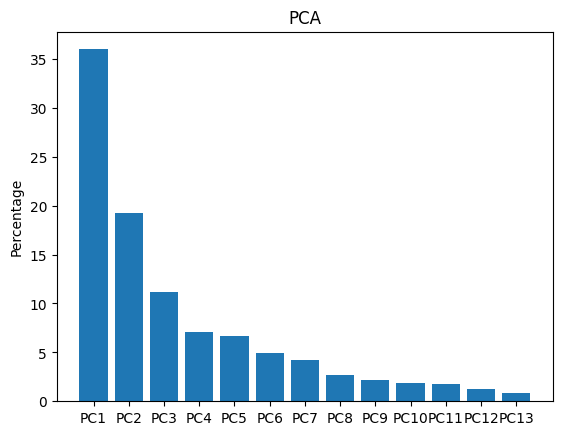

[0.35983071 0.1924128  0.1117946  0.07111109 0.06628744 0.04960367
 0.04246014 0.02697991 0.02224462 0.01898528 0.01734155 0.01295206
 0.00799613]


In [23]:
from sklearn.decomposition import PCA

data_scaled = preprocessing.scale(data)
n = 13

pca_data = PCA(n_components = n)
pca_data.fit(data_scaled)
x_reduced = pca_data.transform(data_scaled)

explained_variance = pca_data.explained_variance_ratio_
plt.bar(range(n), pca_data.explained_variance_ratio_*100)
plt.xticks(range(n), ["PC"+str(i) for i in range(1, n+1)])
plt.title("PCA")
plt.ylabel("Percentage")
plt.show()

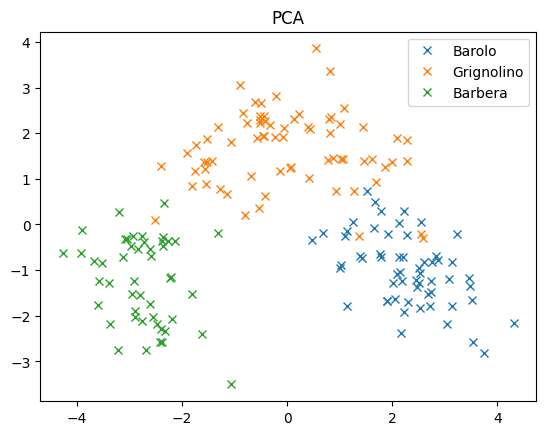

In [27]:
for casta in meta.x.unique():
    index_samples = meta.index[meta.x == casta]-1
    plt.plot(x_reduced[index_samples, 0], x_reduced[index_samples, 1], "x", label=casta)
plt.title("PCA")
plt.legend(loc="best", shadow=False)
plt.show()

6 - Realizar clustering hierarquico dos dados, utilizando a métrica de distância "Manhattan”. Apresenta a àrvore resultante colorindo as folas de acordo com a classe. O que conclui olhando para os resultados?


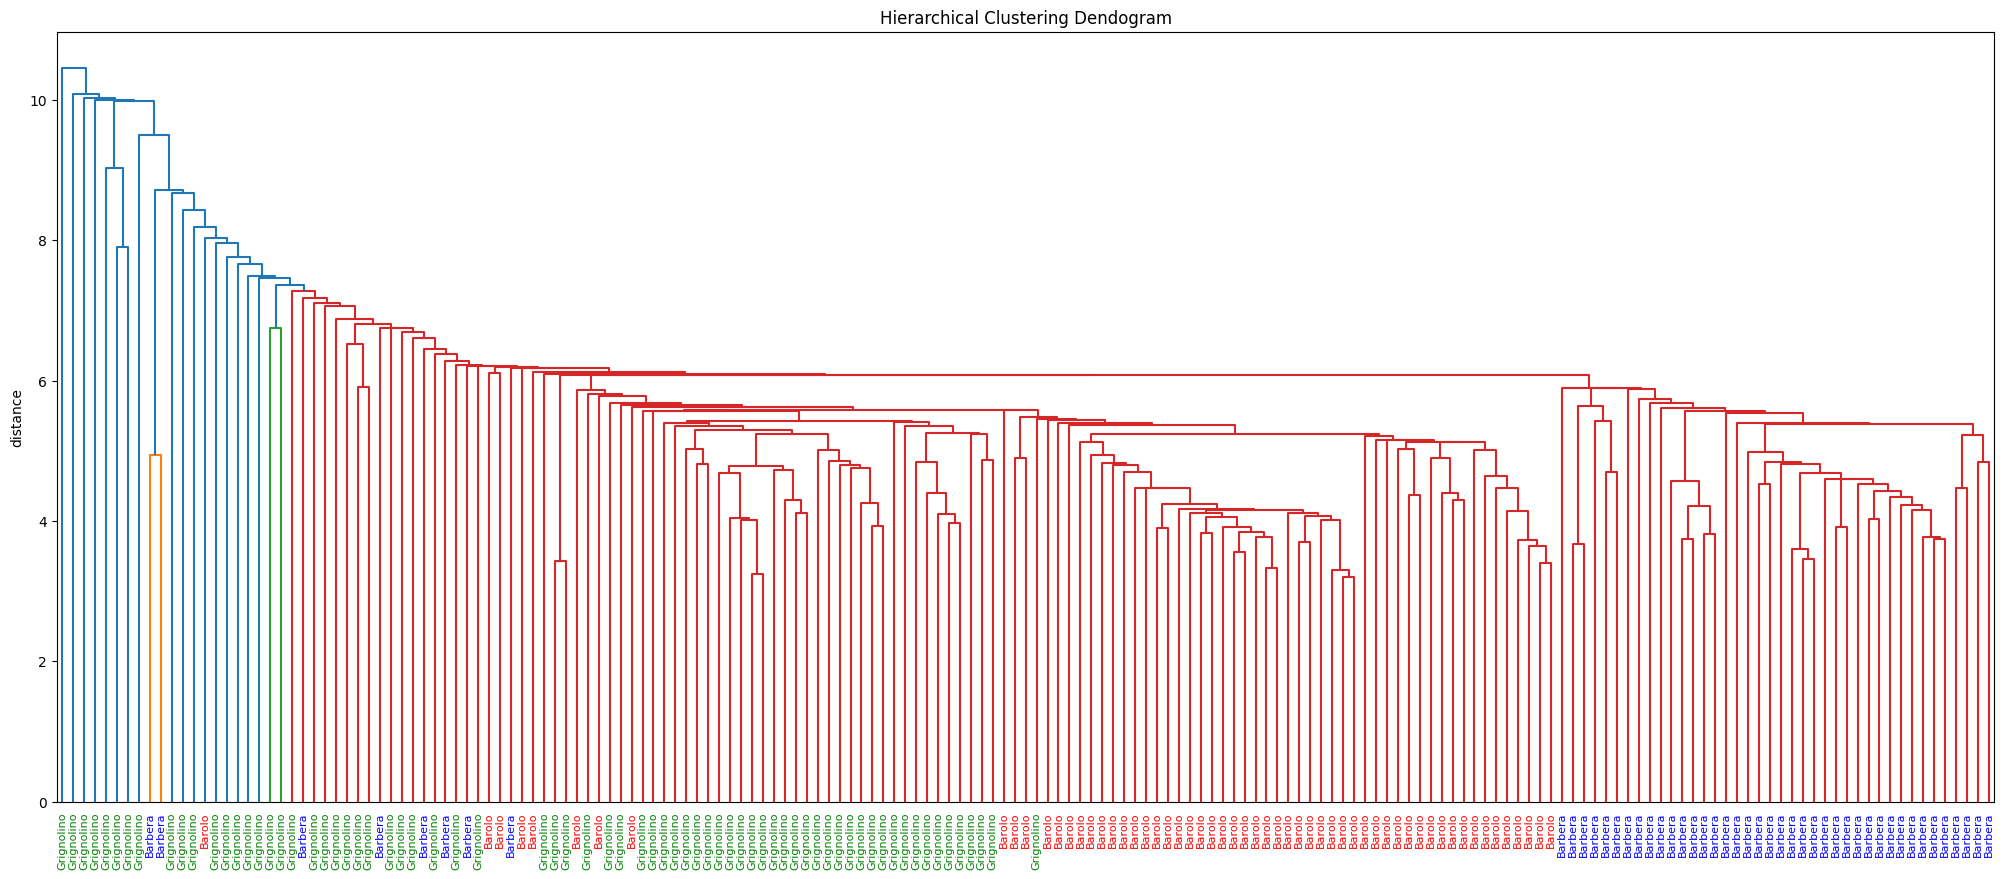

In [27]:
from sklearn import preprocessing

wine_scale = preprocessing.scale(data)

Z = linkage(wine_scale, method="single", metric="cityblock")

# calculate full dendrogram
plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    labels = list(meta.iloc[:, -1]),
    leaf_rotation = 90.,
    leaf_font_size = 8.,
)

plt.title("Hierarchical Clustering Dendogram")
plt.ylabel("distance")

# assignment of the color to the labels
label_colors = {'Barolo': 'r', 'Grignolino': 'g', 'Barbera': 'b'}
ax = plt.gca()
x_labels = ax.get_xmajorticklabels()
for lbl in x_labels:
    lbl.set_color(label_colors[lbl.get_text()])

plt.show()

7 - Aplica a função de clustering k-means aos dados, com k =3, e compara os resultados com os presentes na variavel *wines_labels*. O que conclui desta análise? Cruze os resultados com os obtidos anteriormente.

In [28]:
from sklearn.cluster import KMeans

k=3
kmeans_wine = KMeans(n_clusters=k, max_iter=1000)
kmeans_wine.fit(wine_scale)
labels = kmeans_wine.labels_
centroids = kmeans_wine.cluster_centers_

pd.crosstab(labels, meta["x"], rownames=['clusters'] )

x,Barbera,Barolo,Grignolino
clusters,,,
0,48,0,3
1,0,0,65
2,0,58,3


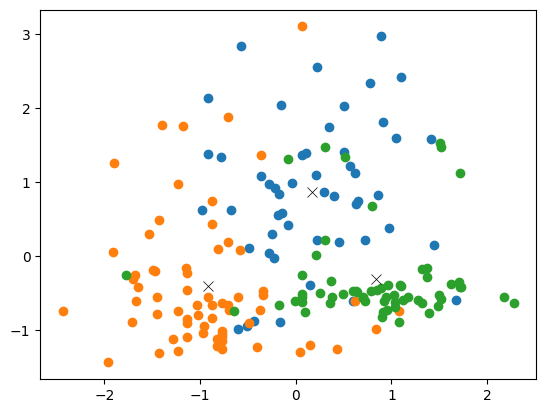

In [32]:
for i in range(k):
    ds = wine_scale[np.where(labels == i)]
    plt.plot(ds[:, 0], ds[:, 1], 'o')
    lines = plt.plot(centroids[i, 0], centroids[i, 1], 'kx')
    plt.setp(lines, ms=7.0) 
    plt.setp(lines, mew=0.5) 
plt.show()